## Visualize spatial distribution of clusters
This is the notebook used for analysis of MDPI-2022 paper. The loading files in this notebook were raw output of AICCA workflow, which has slightly different variable named in netCDF files.

In [1]:
%matplotlib inline
import os
import gc
import re
import glob
import math
import pickle
import netCDF4
import itertools
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
try:
    import cartopy
    import cartopy as cart
    import cartopy.crs as ccrs
except:
    print('You need install cartopy')
    pass
from matplotlib.backends.backend_pdf import PdfPages 

## Extract  latlon coordination from files

In [5]:
def read_netCDF(filename=None, varname=None):
    nc = netCDF4.Dataset(filename, 'r')
    var = nc.variables[f"{varname}"][:]
    nc.close()
    return var

In [6]:
year='2003'
sday=1
eday=1
expname='10021600'
layer_name = 'leaky_re_lu_21'
days = np.array([ str(i).zfill(3) for i in np.arange(sday,eday+1,1)])

In [7]:
# Specify directory where you put your AICCA data
data_basedir='/home/tkurihana/scratch-midway2/data/MODIS-NC-20years/2003-015-105-195-288_053-132-185-315'

In [8]:
# Job directory name to differentiate different job config
expdir='nc2-npb128-cpw1.0-ib1-mb1-mb1'

In [9]:
filelist = []
for day in days:
    filelist.extend(glob.glob(os.path.join(*[data_basedir, year, day, expdir, '*.nc'])))
print(f'Number of NC files {len(filelist)}')

Number of NC files 10378


#### Get longitude and latitude data

In [10]:
lons = read_netCDF(filename=filelist[1], varname='Longitude')

In [11]:
lats = read_netCDF(filename=filelist[1], varname='Latitude')
lats -= 90.0 # need to be -90 90 axis

--------------
## Visualization

In [12]:
def snapshot_plot(
    year, nclusters, expname, layer_name, month,
    label_freq = None,
    avg_array = None,
    cluster_freq = None,
    lons=None, lats=None,
    fsize=20,
    annot_size=20,
    xtsize=20,
    min_drawn_value =0.0001,
    max_drawn_value = 100.0,
    nlevels=11,
    outputdir='./figs',
    figsize=(18,11),
    nrow = 3, ncol = 4,
    cbar_axes=[0.225, 0.00, 0.55, 0.0375],
    ):

    # setup
    ofilename=f'all-{month}{year}-nc-{nclusters}-{expname}-{layer_name}_masked-AvgParam'

    
    fig = plt.figure(figsize=figsize)
    for i in range(nclusters):
        idx = i+1
        ax = fig.add_subplot(nrow, ncol, idx, projection=ccrs.Robinson(central_longitude=180.0))
        levels = [min_drawn_value]+np.linspace(0,max_drawn_value,nlevels).tolist()[1:]

        cmap = plt.cm.nipy_spectral
        cmap.set_under(color='white')
        CS = ax.contourf(lons, lats,label_freq[:,:,i],
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=min_drawn_value,vmax=max_drawn_value,levels=levels, rasterized=True)

        ax.coastlines()
        ax.add_feature(cart.feature.LAND, color='gray',zorder=100, edgecolor='k')
        ax.set_global()
        ax.set_title(f"Cluster {idx} \n RFO {round(cluster_freq[i],1)} % \n COT {round(np.float64(avg_array[i,0]),1)}  CTP {round(np.float64(avg_array[i,1]),1)} hPa", fontsize=fsize)

    plt.subplots_adjust(bottom=0.15,top=1)
    cax = plt.axes(cbar_axes)
    cbar = fig.colorbar(CS,cax=cax,orientation = 'horizontal') # linewidths; default = 1.5
    cbar.ax.set_xlabel('Relative Frequency of Occurrence (%)', fontsize=xtsize)
    cbar.ax.tick_params(labelsize=annot_size)

    fig.tight_layout(pad=0.5,h_pad=0.5)

    ## save
    os.makedirs(outputdir,exist_ok=True)
    pdf = PdfPages(os.path.join( outputdir, f"{ofilename}.pdf") )
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None

--------------
## Analysis: visualize maps

In [13]:
nclusters = 42

In [14]:
def pkl_reader(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

### Load computed data

In [15]:
outputdir = '/home/tkurihana/modis-climate/anl/output'

In [16]:
ctimestamp="2003-015-105-195-288_053-132-185-315"

In [17]:
sday=1 #182
eday=212 #15 #195

In [18]:
""" output from prg_labelprediction.py
"""
try:
    data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{sday}-{eday}-{nclusters}.pkl')
    label_array = data['count']
    label_freq = data['freq']
    cluster_freq = data['cfreq']
except Exception as e:
    print(f'error RFO: {e}')
    pass

In [19]:
try:
    avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{sday}-{eday}-{nclusters}.npy",
                        allow_pickle=True)
except Exception as e:
    avg_array = None
    print(f'error parameter: {e}')
    pass

## MDPI paper production sorted version
Rearange cluster numbers for raw output of AICCA dataset based on relative frquency of occurrence and cloud top pressure.

#### read datafrane values

In [20]:
# I already sorted cluster numbers
df = pd.read_csv("./csvs/sort_cot-ctp_means.csv", index_col=0, header=0)

#### sorting

In [25]:
label_freq.shape, avg_array.shape,cluster_freq.shape

((181, 360, 42), (42, 2), (42,))

In [35]:
def my_sort1(x, df):
    vlist = []
    for i in df['cluster'].to_list():
        vlist.append( np.expand_dims(x[i-1],axis=0) )
    vs = np.concatenate(vlist, axis=0)
    return vs

In [40]:
def my_sort2(x, df):
    vlist = []
    for i in df['cluster'].to_list():
        vlist.append( np.expand_dims(x[:,:,i-1],axis=-1) )
    vs = np.concatenate(vlist, axis=-1)
    return vs

In [41]:
rlabel_freq = my_sort2(label_freq, df)

In [36]:
ravg_array = my_sort1(avg_array, df)
rcluster_freq = my_sort1(cluster_freq, df)

### Run visualization function

/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


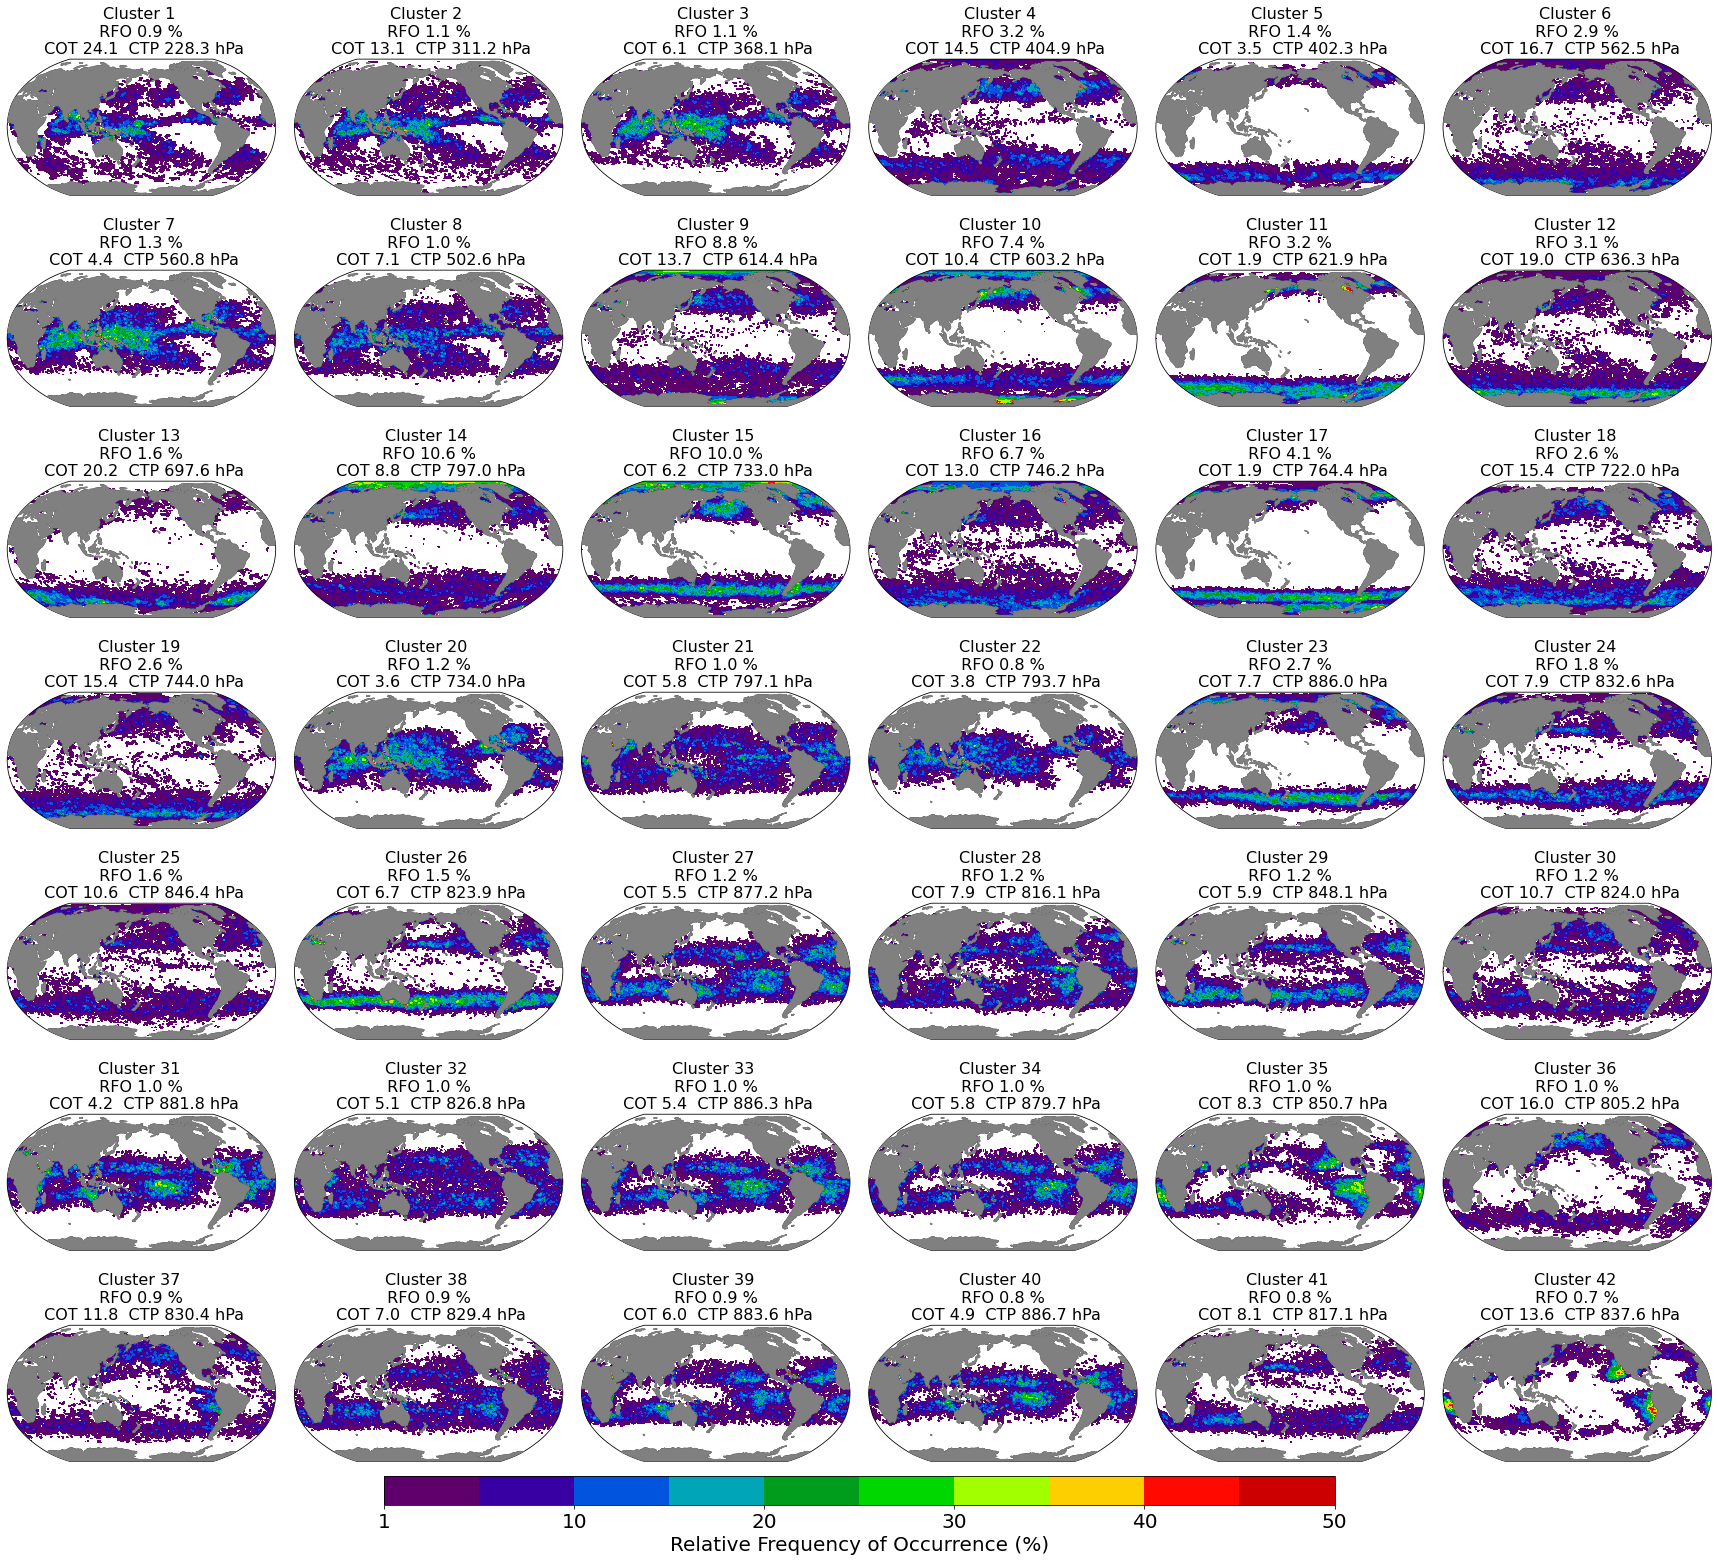

In [43]:
snapshot_plot(year, nclusters, expname, layer_name, '2003-1-212-Jan-July-1percent_v2-sorted',
    rlabel_freq, ravg_array,rcluster_freq,
    lons, lats, 
    fsize=16,annot_size=20, xtsize=20,min_drawn_value = 1.00,max_drawn_value = 50.00,nlevels=11,
              nrow=7, ncol=6,
    figsize=(4*6,3*7),
    cbar_axes=[0.225, 0.00, 0.55, 0.01875]
    ) 